In [1]:
library(tidyverse)

library(grid)
library(gridExtra)
library(patchwork)

source("../evaluation_utils/plots_eda.R")
source("../evaluation_utils/evaluation_funcs.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: viridisLite

Loading required package: limma

Loading required package: BiocParallel


Attaching package: ‘variancePartition’


The following object is masked from ‘package:limma’:

    topTable




In [2]:
cbPalette <- c("#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00")

# Load data

In [ ]:
data_path <- "../evaluation_data/microarray/"

central_uncorrected <- read.csv(paste0(data_path, "before/all_expression_UNION.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
metadata <- read.csv(paste0(data_path, "before/all_metadata.tsv"), sep = "\t", header = TRUE, row.names = 1)

central_corrected <- read.csv(paste0(data_path, "after/central_corrected_UNION.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
fed_corrected <- read.csv(paste0(data_path, "after/FedApp_corrected_data.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)

# remove X from row names
rownames(metadata) <- gsub("X", "", rownames(metadata))
metadata$file <- rownames(metadata)
# order the columns in intensity dataframes

central_uncorrected <- central_uncorrected[, rownames(metadata)]

central_corrected <- central_corrected[rownames(central_uncorrected), rownames(metadata)]
fed_corrected <- fed_corrected[rownames(central_uncorrected), rownames(metadata)]

cat("Loaded data")
cat("Central corrected:", nrow(central_corrected), "rows\n")
cat("Central uncorrected:", nrow(central_uncorrected), "rows\n")
cat("Fed corrected:", nrow(fed_corrected), "rows\n")
cat("Sample metadata:", nrow(metadata), "rows\n\n")



# Checks

## Diagnostic plots

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


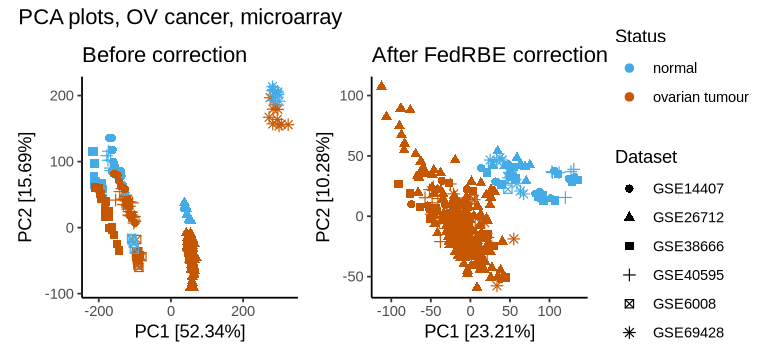

In [ ]:
pca_plot_uncorrected <- pca_plot(central_uncorrected, metadata, 
    title = paste("Before correction"),
    quantitative_col_name = "file", col_col= "Status", shape_col ="Dataset", show_legend=F, cbPalette=c("#44abe7", "#c55702"))

# pca_plot_corrected <- pca_plot(central_corrected, metadata, 
#     title = paste("After central correction"),
#     quantitative_col_name = "file", col_col= "Status", shape_col ="Dataset", show_legend=F, cbPalette=c("#44abe7", "#c55702"))
pca_plot_fed <- pca_plot(fed_corrected, metadata, 
    title = paste("After FedRBE correction"),
    quantitative_col_name = "file", col_col= "Status", shape_col ="Dataset", show_legend=T, cbPalette=c("#44abe7", "#c55702"))


layout <- (pca_plot_uncorrected + pca_plot_fed)
# add layout plot title
layout <- layout + plot_annotation("PCA plots, OV cancer, microarray")

options(repr.plot.width=6, repr.plot.height=3)
layout

Warning message:
“Removed 910422 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 910422 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 910422 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 914198 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 914198 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 914198 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_violin()`).”


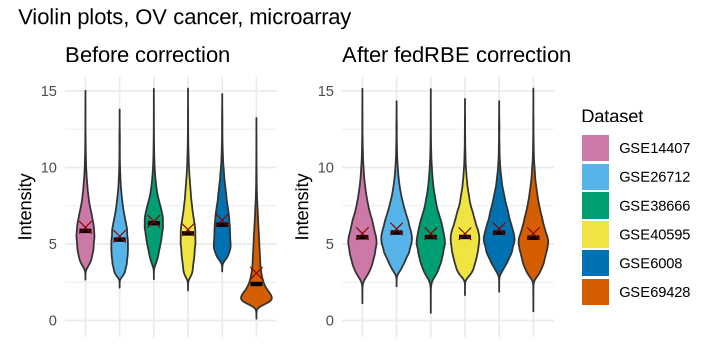

In [9]:
# sample 7000 rows for boxplots
sample_uncor <- central_uncorrected[sample(1:nrow(central_uncorrected), 7000),]
sample_cor <- central_corrected[sample(1:nrow(central_corrected), 7000),]
sample_fed <- fed_corrected[sample(1:nrow(fed_corrected), 7000),]

# # Determine the shared Y-axis limits
y_min <- min(sample_cor, min(sample_uncor, na.rm = TRUE), na.rm = TRUE)
y_max <- max(sample_cor, max(sample_uncor, na.rm = TRUE), na.rm = TRUE)
y_limits <- c(y_min, y_max)

boxplots_uncorrected <- boxplot_plot_groupped(sample_uncor, metadata,
    title = paste("Before correction"),
    quantitativeColumnName = "file",
    color_col = "Dataset", remove_xnames = T, show_legend=F, y_limits = y_limits, cbPalette = cbPalette)
# boxplots_corrected <- boxplot_plot_groupped(sample_cor, metadata, 
#     title = paste("After central correction"),
#     quantitativeColumnName = "file",
#     color_col = "Dataset", remove_xnames = T, show_legend=F, y_limits = y_limits, cbPalette = cbPalette)
boxplots_fed <- boxplot_plot_groupped(sample_fed, metadata,
    title = paste("After fedRBE correction"),
    quantitativeColumnName = "file",
    color_col = "Dataset", remove_xnames = T, y_limits = y_limits, cbPalette = cbPalette)


options(repr.plot.width=6, repr.plot.height=3)
layout <- boxplots_uncorrected | boxplots_fed
layout <- layout + plot_annotation("Violin plots, OV cancer, microarray")
layout

##  Linear model per variable

Following batch effect correction, the percentage of variance explained by the condition should be greater than the batch.

In [11]:
library(variancePartition)

In [12]:
# version of variancePartition package:
packageVersion("variancePartition")

[1] ‘1.32.2’

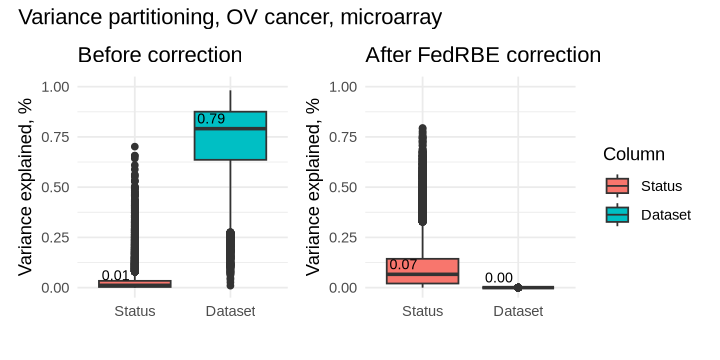

In [13]:
lmpv_plot_uncorrected <- lmpv_plot(central_uncorrected, metadata, 
    title = paste("Before correction"),
    show_legend=F)
# lmpv_plots_corrected <- lmpv_plot(central_corrected, metadata, 
#     title = paste("After central correction"), show_legend=F)
lmpv_plot_fed <- lmpv_plot(fed_corrected, metadata, 
    title = paste("After FedRBE correction"), show_legend=T)


layout <- (lmpv_plot_uncorrected + lmpv_plot_fed)
layout <- layout + plot_annotation("Variance partitioning, OV cancer, microarray")
options(repr.plot.width=6, repr.plot.height=3)
layout

# Session info

In [16]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 24.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/yuliya/miniforge3/envs/fedRBE/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] variancePartition_1.32.2 BiocParallel_1.36.0      limma_3.58.1            
 [4] viridis_0.6.5            viridisLite_0.4.2        ggsci_3.2.0             
 [7] umap_0.2.10.0            patchwork_1.3.0     